In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)


en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [7]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [8]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [9]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [10]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))


print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
766 ----> hola
27 ----> !
6 ----> ¿
45 ----> como
51 ----> estas
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
679 ----> hi
37 ----> !
52 ----> how
24 ----> are
6 ----> you
7 ----> ?
2 ----> <end>


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [12]:
print(vocab_tar_size)
print(vocab_inp_size)

4935
9414


In [ ]:
class NMT(tf.keras.Model):
    def __init__(self, vocab_inp_size, vocab_targ_size, embedding_dim, units):
        super(NMT, self).__init__()
        # Encoding
        self.enc_embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size, output_dim=embedding_dim)
        self.enc_gru = tf.keras.layers.GRU(units=units, return_sequences=True, return_state=True)
        # Attention
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        self.w3 = tf.keras.layers.Dense(1)
        # Decoding
        self.dec_embedding = tf.keras.layers.Embedding(input_dim=vocab_targ_size, output_dim=embedding_dim)
        self.dec_gru = tf.keras.layers.GRU(units=units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(units=vocab_targ_size)

    def call(self, inputs, target=None, luong=False, training=True):
        preds = []
        attention = []
        # Encoding
        enc_embedded = self.enc_embedding(inputs)
        enc_output, enc_hidden = self.enc_gru(enc_embedded)
        # Decoding and Attention
        if training or target:
            dec_input = tf.expand_dims(target[:, 0], 1)
            start = 1
            end = target.shape[1]
        else:
            dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
            start = 0
            end = max_length_targ
        dec_hidden = enc_hidden
        for i in range(start, end):
            # Attention
            if luong:
                score = tf.matmul(self.w1(enc_output), tf.transpose(tf.expand_dims(dec_hidden, 1), perm=[0, 2, 1]))
            else:
                score = self.w3(tf.nn.tanh(self.w1(tf.expand_dims(dec_hidden, 1)) + self.w2(enc_output)))
            attention_weights = tf.nn.softmax(score, 1)
            context = tf.reduce_sum(attention_weights*enc_output, 1)
            attention.append(attention_weights)
            # Decoding
            dec_embedded = self.dec_embedding(dec_input)
            dec_output, dec_hidden = self.dec_gru(dec_embedded, initial_state=[context])
            pred = self.dense(dec_output)
            preds.append(pred)
            dec_input = tf.expand_dims(target[:, i], 1) if training else tf.argmax(pred, -1)
        return tf.concat(preds, 1), attention


In [ ]:
class NMT(tf.keras.Model):
    def __init__(self, vocab_inp_size, vocab_targ_size, embedding_dim, units):
        super(NMT, self).__init__()
        #Encoder
        self.enc_embedding = tf.keras.layers.Embedding(input_dim=vocab_inp_size,
                                                       output_dim=embedding_dim)
        self.enc_rnn = tf.keras.layers.GRU(units=units, return_sequences=True, return_state=True)
        #Attention
        self.w1 = tf.keras.layers.Dense(units=units)
        self.w2 = tf.keras.layers.Dense(units=units)
        self.w3 = tf.keras.layers.Dense(units=1)
        #Decoder
        self.dec_embedding = tf.keras.layers.Embedding(input_dim=vocab_targ_size,
                                                       output_dim=embedding_dim)
        self.dec_rnn = tf.keras.layers.GRU(units=units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(units=vocab_targ_size)

    def call(self, input, target, training):
        enc_embedded = self.enc_embedding(input) #batch_size, seq_len, embedding_dim
        enc_output, enc_state = self.enc_rnn(enc_embedded)

        for 

In [ ]:
batch_size = 64
input_dim = 65
embedding_dim = 256
rnn_units = 1024

BUFFER_SIZE = len(input_tensor_train)
steps_per_epoch = len(input_tensor_train)//batch_size

model = NMT(vocab_inp_size, vocab_tar_size, embedding_dim, rnn_units)


optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_obj(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

@tf.function
def train_step(input, target):
    with tf.GradientTape() as tape:
        preds, _ = model(inputs=input, target=target)
        loss = loss_function(target[:, 1:], preds)
        

    variables = model.trainable_variables
    grad = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grad, variables))
        
    return loss                

In [ ]:
checkpoint_dir = '/gdrive/My Drive/Colab Notebooks/checkpoints/NMT'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_gru")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        loss = train_step(inp, targ)

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print(f'Epoch {epoch + 1} Loss {loss}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 1.6125599145889282
Time taken for 1 epoch 77.1848304271698 sec

Epoch 2 Loss 1.1875786781311035
Time taken for 1 epoch 66.96861672401428 sec

Epoch 3 Loss 0.8951773643493652
Time taken for 1 epoch 65.78566384315491 sec

Epoch 4 Loss 0.6039422750473022
Time taken for 1 epoch 66.42562818527222 sec

Epoch 5 Loss 0.3897191882133484
Time taken for 1 epoch 65.80089521408081 sec

Epoch 6 Loss 0.32650628685951233
Time taken for 1 epoch 66.82388091087341 sec

Epoch 7 Loss 0.23681119084358215
Time taken for 1 epoch 65.62593293190002 sec

Epoch 8 Loss 0.13849902153015137
Time taken for 1 epoch 66.72990942001343 sec

Epoch 9 Loss 0.151264488697052
Time taken for 1 epoch 65.90584635734558 sec

Epoch 10 Loss 0.09359820187091827
Time taken for 1 epoch 66.43696689605713 sec



In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    target = [targ_lang.word_index['<start>']]
    predictions, attention = model(inputs, training=False)

    for t in range(max_length_targ):

        attention_weights = tf.reshape(attention[t], (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(tf.squeeze(predictions[:, t, :], 0)).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
model.summary()

Model: "nmt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2409984   
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  1049600   
_________________________________________________________________
dense_1 (Dense)              multiple                  1049600   
_________________________________________________________________
dense_2 (Dense)              multiple                  1025      
_________________________________________________________________
embedding_1 (Embedding)      multiple                  1263360   
_________________________________________________________________
gru_1 (GRU)                  multiple                  3938304 

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


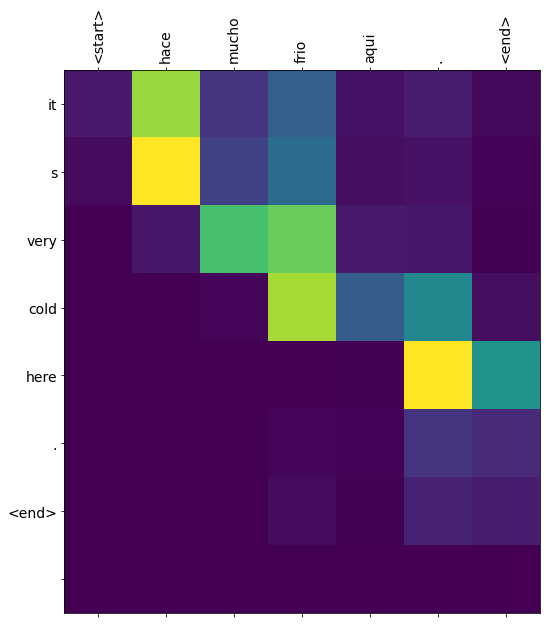

In [ ]:
translate(u'hace mucho frio aqui.') #no stateful in decoder

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


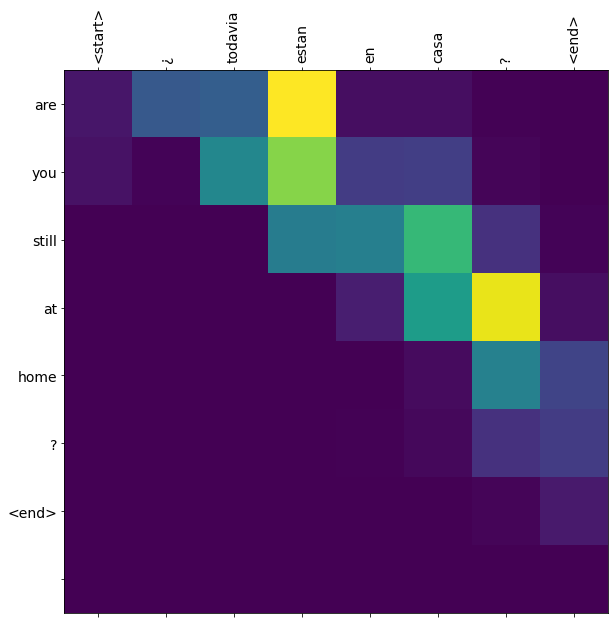

In [ ]:
translate(u'¿todavia estan en casa?') #no stateful in decoder

Input: <start> te amo desde mi corazon <end>
Predicted translation: i love you my heart . <end> 


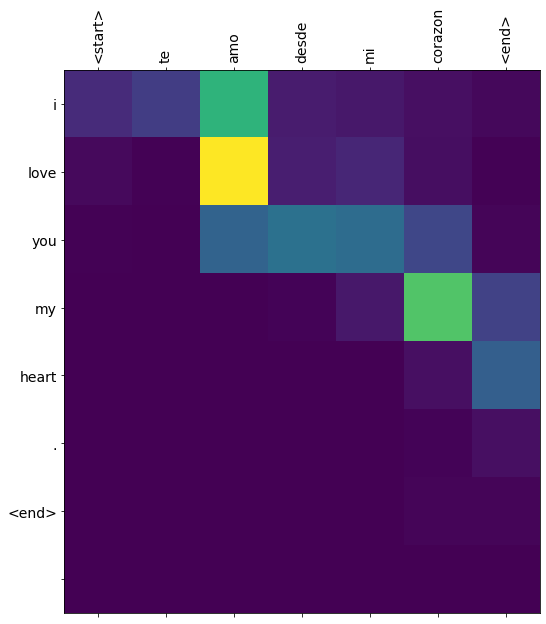

In [ ]:
translate(u"te amo desde mi corazón") #no stateful in decoder